# Merge PNG + NIR (Building)
---

In [93]:
import os
import glob
import numpy as np
import cv2
from tqdm import tqdm
import re
import rasterio
import matplotlib.pyplot as plt
import h5py

### A. 파일 경로 설정

In [3]:
# 개인 디렉토리 구조에 맞게 변경하여 주세요
DATA_DIR = os.path.join(os.getenv('HOME'), 'workspace/Hackerton/RSI_OP_NIA_AIHUB')
BUILDING_DIR = os.path.join(DATA_DIR, 'buildings')

TRAIN_IMG_DIR = os.path.join(BUILDING_DIR, 'training/raw')
TRAIN_LABEL_DIR = os.path.join(BUILDING_DIR, 'training/label')
VAL_IMG_DIR = os.path.join(BUILDING_DIR, 'validation/raw')
VAL_LABEL_DIR = os.path.join(BUILDING_DIR, 'validation/label')

In [4]:
b_datset_list_path = {
    'train': os.path.join(DATA_DIR, 'B_train_list.txt'),
    'val': os.path.join(DATA_DIR, 'B_val_list.txt'),
    'test': os.path.join(DATA_DIR, 'B_test_list.txt')
}

In [5]:
def read_file_path(path_list):
    file_path_dict = {}
    for key, path in path_list.items():
        with open(path, 'r') as f:
            IMG_BASE_PATH = VAL_IMG_DIR if key == 'test' else TRAIN_IMG_DIR
            LABEL_BASE_PATH = VAL_LABEL_DIR if key == 'test' else TRAIN_LABEL_DIR
            
            _list = f.readlines()
            _list = [ file_path.split("\n")[0] for file_path in _list]
            img_list = [ f'{IMG_BASE_PATH}/{file_path}' for file_path in _list]
            label_list = [ f'{LABEL_BASE_PATH}/{file_path}' for file_path in _list]
            
            file_path_dict[key] = {'img': img_list, 'label': label_list}
    return file_path_dict

b_datset_list = read_file_path(b_datset_list_path)

In [6]:
b_datset_list['train']['img'][:5], b_datset_list['train']['label'][:5]

(['/home/aiffel-dj1/workspace/Hackerton/RSI_OP_NIA_AIHUB/buildings/training/raw/BLD00001_PS3_K3A_NIA0276.png',
  '/home/aiffel-dj1/workspace/Hackerton/RSI_OP_NIA_AIHUB/buildings/training/raw/BLD00002_PS3_K3A_NIA0276.png',
  '/home/aiffel-dj1/workspace/Hackerton/RSI_OP_NIA_AIHUB/buildings/training/raw/BLD00004_PS3_K3A_NIA0276.png',
  '/home/aiffel-dj1/workspace/Hackerton/RSI_OP_NIA_AIHUB/buildings/training/raw/BLD00008_PS3_K3A_NIA0276.png',
  '/home/aiffel-dj1/workspace/Hackerton/RSI_OP_NIA_AIHUB/buildings/training/raw/BLD00011_PS3_K3A_NIA0276.png'],
 ['/home/aiffel-dj1/workspace/Hackerton/RSI_OP_NIA_AIHUB/buildings/training/label/BLD00001_PS3_K3A_NIA0276.png',
  '/home/aiffel-dj1/workspace/Hackerton/RSI_OP_NIA_AIHUB/buildings/training/label/BLD00002_PS3_K3A_NIA0276.png',
  '/home/aiffel-dj1/workspace/Hackerton/RSI_OP_NIA_AIHUB/buildings/training/label/BLD00004_PS3_K3A_NIA0276.png',
  '/home/aiffel-dj1/workspace/Hackerton/RSI_OP_NIA_AIHUB/buildings/training/label/BLD00008_PS3_K3A_NIA027

In [7]:
print(f'num of buildings train: {len(b_datset_list["train"]["img"])}')
print(f'num of buildings validation: {len(b_datset_list["val"]["img"])}')
print(f'num of buildings test: {len(b_datset_list["test"]["img"])}\n')

num of buildings train: 1088
num of buildings validation: 150
num of buildings test: 159



In [8]:
train_shape = (len(b_datset_list["train"]["img"]), 1024, 1024, 3)
val_shape = (len(b_datset_list["val"]["img"]), 1024, 1024, 3)
test_shape = (len(b_datset_list["test"]["img"]), 1024, 1024, 3)
train_shape, val_shape, test_shape

((1088, 1024, 1024, 3), (150, 1024, 1024, 3), (159, 1024, 1024, 3))

In [9]:
def tiff_path_to_png_path(path):
    png_path = re.sub('_PS4_', '_PS3_', path)
    png_path = re.sub('tif', 'png', png_path)
    return png_path

def png_path_to_tiff_path(path):
    tif_path = re.sub('_PS3_', '_PS4_', path)
    tif_path = re.sub('png', 'tif', tif_path)
    return tif_path

### B. sample

In [21]:
sample_png_path = b_datset_list["train"]["img"][0]
sample_label_path = b_datset_list["train"]["label"][0]
sample_tif_path = png_path_to_tiff_path(sample_png_path)
print(sample_png_path)
print(sample_label_path)
print(sample_tiff_path)

/home/aiffel-dj1/workspace/Hackerton/RSI_OP_NIA_AIHUB/buildings/training/raw/BLD00001_PS3_K3A_NIA0276.png
/home/aiffel-dj1/workspace/Hackerton/RSI_OP_NIA_AIHUB/buildings/training/label/BLD00001_PS3_K3A_NIA0276.png
/home/aiffel-dj1/workspace/Hackerton/RSI_OP_NIA_AIHUB/buildings/training/raw/BLD00001_PS4_K3A_NIA0276.tif


In [26]:
def show_4_channel(img):
    plt.figure(figsize=(10, 10))

    plt.subplot(121)
    plt.imshow(img[:,:, :3].astype(np.uint8))
    plt.axis('off') 

    plt.subplot(122)
    plt.imshow(img[:,:, 3], cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

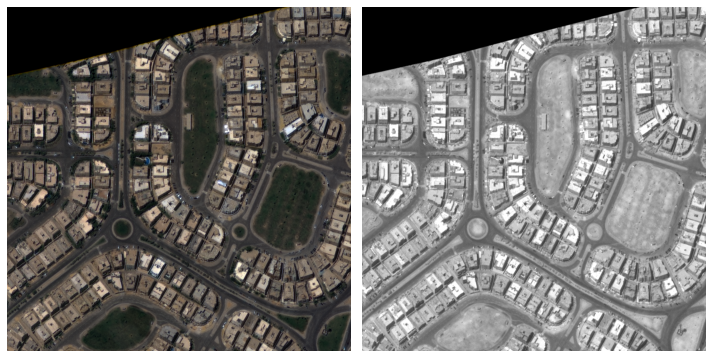

In [91]:
with rasterio.open(sample_tif_path) as src:
    bg = cv2.cvtColor(cv2.imread(sample_png_path), cv2.COLOR_BGR2RGB)
    
    nir = src.read(4)
    nir = (nir - nir.min()) / (nir.max() - nir.min())*255
    nir = np.reshape(nir, (1024, 1024, 1))
    
    merged = np.concatenate((bg, nir), axis=2).astype(np.uint8)
    show_4_channel(merged)

### C. hdf5 파일 생성
hdf5 구성
 - group : train
    - dataset : img
    - dataset : label
- group : val
    - dataset : img
    - dataset : label
- group : test
    - dataset : img
    - dataset : label

In [97]:
with h5py.File('./LV1_PNG_DATASET_B_TIF.h5', 'w') as h5:
    for key in ['train', 'val', 'test']:  
        # create building train dataset
        group = h5.create_group(key)
        group.create_dataset('img', (len(b_datset_list[key]["img"]), 1024, 1024, 4), np.uint8)
        group.create_dataset('label', (len(b_datset_list[key]["img"]), 1024, 1024, 3), np.uint8)

        # write the images
        for i in tqdm(range(len(b_datset_list[key]["img"])), desc=f'Write {key} image'):
            png_path = b_datset_list[key]['img'][i]
            tif_path = png_path_to_tiff_path(png_path)
            label_path =  b_datset_list[key]['label'][i]

            with rasterio.open(tif_path) as src:
                bg = cv2.cvtColor(cv2.imread(png_path), cv2.COLOR_BGR2RGB)

                nir = src.read(4)
                nir = (nir - nir.min()) / (nir.max() - nir.min())*255
                nir = np.reshape(nir, (1024, 1024, 1))

                merged = np.concatenate((bg, nir), axis=2).astype(np.uint8)    
                label = cv2.cvtColor(cv2.imread(label_path), cv2.COLOR_BGR2RGB)

                group['img'][i, ...] = merged
                group['label'][i, ...] = label

Write test image: 100%|██████████| 159/159 [00:14<00:00, 10.62it/s]


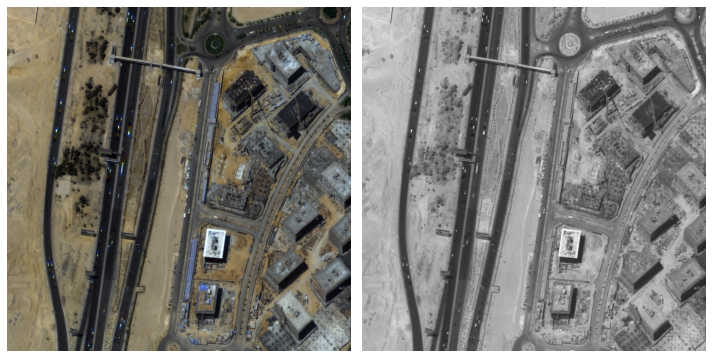

In [100]:
with h5py.File('./LV1_PNG_DATASET_B_TIF.h5', 'r') as h5:
    show_4_channel(h5['train']['img'][10])